In [ ]:
!pip uninstall tensorflow-addons
!pip install tensorflow-addons==0.10.0

Uninstalling tensorflow-addons-0.10.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/_foo.cpython-36m-x86_64-linux-gnu.so
    /usr/local/lib/python3.6/dist-packages/tensorflow_addons-0.10.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_addons/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-addons-0.10.0
  Using cached https://files.pythonhosted.org/packages/0e/ce/ed8472bf2b93b53702f28d91caee52181f7a10bee6eec0617a71dea12fa6/tensorflow_addons-0.10.0-cp36-cp36m-manylinux2010_x86_64.whl


In [18]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tensorflow_addons.image import utils as img_utils
import tensorflow_probability as tfp
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from random import randrange
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import numpy as np
from numpy import expand_dims
import sys
import time

g = tf.random.Generator.from_seed(int(np.random.uniform(low=300, high=9000)))

def angles_to_projective_transforms(angle, image_width, image_height):
  with tf.name_scope("rotate_parent"):
    angle_or_angles = tf.convert_to_tensor(angle, name="angles", dtype=tf.dtypes.float32)
    angles = angle_or_angles[None]
    x_offset = ((image_width - 1) - (tf.math.cos(angles) * (image_width - 1) - tf.math.sin(angles) * (image_height - 1))) / 2.0
    y_offset = ((image_height - 1)- (tf.math.sin(angles) * (image_width - 1) + tf.math.cos(angles) * (image_height - 1))) / 2.0
    num_angles = tf.shape(angles)[0]
  return tf.concat([tf.math.cos(angles)[:, None],-tf.math.sin(angles)[:, None],x_offset[:, None],tf.math.sin(angles)[:, None],tf.math.cos(angles)[:, None],y_offset[:, None],tf.zeros((1, 2))],axis=1)

def rotate(image, angle):
  with tf.name_scope("rotate"):
    image = tf.convert_to_tensor(image)
    img = img_utils.to_4D_image(image)
    ndim = image.get_shape().ndims
    image_height = tf.cast(img.shape[1], tf.dtypes.float32)
    image_width = tf.cast(img.shape[2], tf.dtypes.float32)
    rotation_key = angles_to_projective_transforms(angle, image_width, image_height)
    output = tfa.image.transform(img, rotation_key, interpolation="NEAREST")
  return img_utils.from_4D_image(output, ndim)
  
def rand_number(low, high):
  global g
  scale = g.uniform(minval= low, maxval= high, shape = (), dtype=tf.float32)
  return scale

def preprocessing_selection(choice):
  def classification(image, label):

    image = tf.cast(image, tf.float32)
    width = tf.cast(image.shape[1], tf.float32)
    height = tf.cast(image.shape[2], tf.int32)
    low = tf.cast(128, tf.dtypes.float32)[None]
    high = tf.cast(448, tf.dtypes.float32)[None]
    scale = tf.py_function(rand_number, [low, high], [tf.float32])
    aspect = tf.py_function(rand_number, [.75, 1.25], [tf.float32])
    deg = tf.py_function(rand_number, [-7.0, 7.0], [tf.float32])
    scale = tf.cast(scale, dtype= tf.int32)[0][0]
    deg = tf.cast(deg, dtype=tf.float32)[0]
    aspect = tf.cast(aspect, dtype=tf.float32)[0]
    nheight = tf.cast(width/aspect, dtype= tf.int32)
    nwidth = tf.cast(width, dtype= tf.int32)


    image = tf.image.resize(image, size = (nwidth, nheight))
    image = tf.image.resize_with_crop_or_pad(image, target_height = scale, target_width = scale)
    image = tf.image.resize_with_pad(image, target_width=224, target_height=224)
    image = rotate(image, deg)
    image = tf.image.random_brightness(image=image, max_delta=.75)
    image = tf.image.random_saturation(image=image, lower = 0.75, upper=1.25)
    image = tf.image.random_hue(image=image, max_delta=.1)
    image = tf.clip_by_value(image / 255, 0, 1)
    return image, label

  def priming(image, label):
    image = tf.cast(image, tf.float32)
    width = tf.cast(image.shape[1], tf.float32)
    height = tf.cast(image.shape[2], tf.int32)
    low = tf.cast(448, tf.dtypes.float32)[None]
    high = tf.cast(512, tf.dtypes.float32)[None]
    scale = tf.py_function(rand_number, [low, high], [tf.float32])
    scale = tf.cast(scale, dtype= tf.int32)[0][0]
    image = tf.image.resize_with_crop_or_pad(image, target_height = scale, target_width = scale)
    image = tf.image.resize_with_pad(image, target_width=448, target_height=448)
    image = image / 255
    return image, label

  def detection(image, label):
    image = tf.cast(image, tf.float32)
    low = tf.cast(128, tf.dtypes.float32)[None]
    high = tf.cast(448, tf.dtypes.float32)[None]
    resize_num = tf.py_function(rand_number, [10.0, 19.0], [tf.float32])
    resize_num = tf.cast(resize_num, dtype= tf.int32)[0]*32
    image = tf.image.resize_with_pad(image, target_width=resize_num, target_height=resize_num)
    image = tf.image.random_brightness(image=image, max_delta=.75)
    image = tf.image.random_saturation(image=image, lower = 0.75, upper=1.25)
    image = tf.image.random_hue(image=image, max_delta=.1)
    image = image / 255
    return image, label

  try:
    if choice.lower() == "detection":
      return detection
    elif choice.lower() == "classification":
      return classification
    elif choice.lower() == "priming":
      return priming
    else:
      NameError('Invalid Input')
  except:
    raise NameError('Invalid Input')

def normalize_selection(height, width):
  def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize_with_pad(image, target_width=height, target_height=width)
    image = image / 255
    return image, label
  return normalize

def detection_normalize(image, label):
  image = tf.cast(image, tf.float32)
  low = tf.cast(128, tf.dtypes.float32)[None]
  high = tf.cast(448, tf.dtypes.float32)[None]
  resize_num = tf.py_function(rand_number, [10.0, 19.0], [tf.float32])
  resize_num = tf.cast(resize_num, dtype= tf.int32)[0]*32
  image = tf.image.resize_with_pad(image, target_width=resize_num, target_height=resize_num)
  image = image / 255
  return image, label

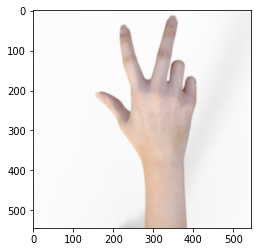

10.366009950637817


In [19]:
#param train, top%, bottom%, type Splits before 
def preprocessing(training_dataset, data_augmentation_split, type_of_preprocessing, size_of_dataset, num_of_batches):
  data_augmentation_split = int((data_augmentation_split/100)*size_of_dataset)
  non_preprocessed_split = size_of_dataset - data_augmentation_split

  data_augmentation_dataset = training_dataset.take(data_augmentation_split)
  remaining = training_dataset.skip(data_augmentation_split)  
  non_preprocessed_split = remaining.take(non_preprocessed_split)

  preprocessing_function = preprocessing_selection(type_of_preprocessing)
  data_augmentation_dataset = data_augmentation_dataset.map(preprocessing_function, num_parallel_calls= tf.data.experimental.AUTOTUNE)

  if type_of_preprocessing == "detection":
    non_preprocessed_split = non_preprocessed_split.map(detection_normalize, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    if num_of_batches > 1:
      raise SyntaxError("For detection preprocessing, number of batches must be 1.")
    else:
      training_dataset= data_augmentation_dataset.concatenate(non_preprocessed_split)
      training_dataset = training_dataset.shuffle(size_of_dataset)
      training_dataset = training_dataset.batch(1).prefetch(1)
      return training_dataset

  elif type_of_preprocessing == "classification":
    normalize = normalize_selection(224, 224)
    non_preprocessed_split = non_preprocessed_split.map(normalize, num_parallel_calls = tf.data.experimental.AUTOTUNE)

  elif type_of_preprocessing == "priming":
    normalize = normalize_selection(448, 448)
    non_preprocessed_split = non_preprocessed_split.map(normalize, num_parallel_calls = tf.data.experimental.AUTOTUNE)

  training_dataset= data_augmentation_dataset.concatenate(non_preprocessed_split)
  training_dataset = training_dataset.shuffle(size_of_dataset)
  training_dataset = training_dataset.batch(int(size_of_dataset/num_of_batches)).prefetch(tf.data.experimental.AUTOTUNE)
  return training_dataset



Train, Info = tfds.load('rock_paper_scissors', split='train', with_info=True, as_supervised= True, shuffle_files=False)
Size = int(Info.splits['train'].num_examples)
Train = preprocessing(Train, 50,"detection", Size, 1)

#benchmark
start = time.time()
count = 0
for x in range(30):
  train_ds = Train.take(1)
  for i,j in train_ds:
    for image in i:
      plt.imshow(image)
      plt.show()
    break
  break
  print(count)
  count += 1
stop = time.time()
print(stop - start)

